In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from pycta.portfolio import Portfolio
from pycta.analysis import Analysis

In [12]:
# Load prices
prices = pd.read_csv("data/p_ob.csv", index_col=0, parse_dates=True).ffill().truncate(before="1970-01-01")

We use the system:
$$\mathrm{CashPosition}=\frac{f(\mathrm{Price})}{\mathrm{Volatility(Returns)}}$$

This is very problematic:
* Prices may live on very different scales, hence trying to find a more universal function $f$ is almost impossible. The sign-function was a good choice as the results don't depend on the scale of the argument.
* Price may come with all sorts of spikes/outliers/problems.

We need a simple price filter process
* We compute volatility-adjusted returns, filter them and compute prices from those returns. 
* Don't call it Winsorizing in Switzerland. We apply Huber functions. 


In [13]:
def filter(price, volatility=32,clip=4.2, min_periods=300):    
    r = np.log(price).diff()
    vola = r.ewm(com=volatility, min_periods=min_periods).std()
    price_adj = (r/vola).clip(-clip, clip).cumsum()
    return price_adj

### Oscillators
* All prices are now following a standard arithmetic Brownian motion with std $1$.
* What we want is the difference of two moving means (exponentially weighted) to have a constant std regardless of the two lengths.
* An oscillator is the **scaled difference of two moving averages**.


In [14]:
import numpy as np
def osc(prices, fast=32, slow=96, scaling=True):
    diff = prices.ewm(com=fast-1).mean() - prices.ewm(com=slow-1).mean()
    if scaling:
        s = diff.std()
    else:
        s = 1

    return diff/s

In [15]:
from numpy.random import randn
import pandas as pd
price = pd.Series(data=randn(100000)).cumsum()

o = osc(price, 40, 200, scaling=True)
print("The std for the oscillator (Should be close to 1.0):")
print(np.std(o))

The std for the oscillator (Should be close to 1.0):
0.9999949999875


In [16]:
#from pycta.signal import osc

# take two moving averages and apply tanh
def f(price, slow=96, fast=32, clip=3):
    # construct a fake-price, those fake-prices have homescedastic returns
    price_adj = filter(price, volatility=slow, clip=clip)
    # compute mu
    mu = np.tanh(osc(price_adj, fast=fast, slow=slow))
    return mu/price.pct_change().ewm(com=slow, min_periods=300).std()

In [17]:
portfolio = Portfolio(prices=prices, position=prices.apply(f))

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
a = Analysis(portfolio.nav())
a.performance

Performance number
Annua Return                        12.80
Annua Volatility                    16.03
Annua Sharpe Ratio (r_f = 0)         0.80
Max Drawdown                        49.11
Return                          36,443.29
Kurtosis                             9.03
dtype: object

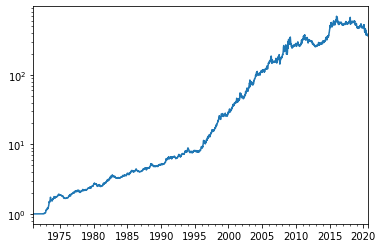

In [19]:
a.nav.plot(logy=True)
plt.show()

In [20]:
a.monthlytable

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,STDev,YTD
Year,,,,,,,,,,,,,,
2020,1.88%,-7.68%,-8.34%,3.73%,-7.56%,-3.78%,-1.72%,-3.92%,,,,,15.60%,-24.88%
2019,-10.49%,-1.20%,0.26%,3.03%,-3.22%,4.70%,2.74%,6.96%,-7.29%,-4.21%,1.17%,-0.32%,17.36%,-8.91%
2018,7.18%,-10.75%,-0.92%,2.44%,-3.41%,1.07%,0.61%,4.89%,-1.72%,-8.22%,-2.60%,1.55%,17.56%,-10.75%
2017,-1.22%,4.62%,-0.49%,2.73%,2.38%,-3.79%,0.43%,0.19%,-0.97%,6.03%,0.36%,3.67%,9.66%,14.38%
2016,7.88%,3.16%,-12.37%,-8.32%,-0.38%,6.09%,1.10%,-2.47%,3.34%,-7.25%,-0.37%,-0.95%,20.74%,-11.87%
2015,15.83%,-3.84%,13.69%,-10.39%,5.22%,-4.08%,15.62%,-6.32%,4.68%,-5.96%,10.98%,-1.43%,32.56%,33.57%
2014,-1.44%,4.05%,-1.07%,3.09%,2.75%,4.20%,-2.93%,5.03%,5.52%,-3.08%,12.94%,11.79%,17.96%,47.41%
2013,1.01%,-0.12%,2.19%,4.40%,1.92%,-3.50%,3.31%,-3.04%,0.66%,3.57%,4.38%,1.29%,8.97%,16.89%
2012,1.29%,-2.87%,-0.19%,0.96%,-1.78%,-9.27%,3.86%,-3.73%,-3.07%,-1.66%,-0.23%,-0.97%,11.25%,-16.79%


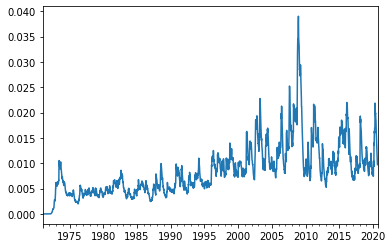

In [21]:
a.std.plot(kind="line")
plt.show()

This system is still **univariate** and lacks **integrated risk management**:

$$\mathrm{CashPosition}=\frac{f(\mathrm{Filter}(\mathrm{Price}))}{\mathrm{Volatility(Returns)}}=\frac{\mu}{\mathrm{Volatility}}$$

Some hedge funds stop here. All energy goes into constructing $\mu$.

* Suitable as it is possible to add/remove additional systems on the fly.
* A typical CTA would run with a set of $5$ or $6$ functions $f$ acting on approx. $100$ assets. 
* Organisation by asset group.
* Scaled signals make it easy to apply functions such as $\tanh$ or combine various signals in a regression problem.